# SETUP

In [12]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import subprocess
import feather
from tqdm.notebook import tqdm
import itertools as it
import inspect
import shutil
import re
from collections import namedtuple
from pyprojroot import here
from joblib import Parallel, delayed
import matplotlib as mpl
from matplotlib import pyplot as plt

In [13]:
root = here()

In [14]:
def load_tide(wdir, filename):
    '''
    Function that loads the tidal curve constructed by make_tides.R
    and sets the index to the Datetime column.
    '''
    fp = wdir / filename
    tides = feather.read_dataframe(fp)
    tides = tides.set_index("Datetime")

    return tides

def return_bound_conc(bound_conc, method, timestamp=None):
    if method == "constant":
        return bound_conc
    elif method == "weekly":
        week = timestamp.week
        bound_conc = sed_conc.loc[week].values[0]
        return bound_conc


def accumulate_sediment(conc, settle_rate, timestep):
    deposited_sediment = settle_rate * conc * timestep
    return deposited_sediment


def aggrade(start_elev, sediment, organic, compaction, subsidence):
    elev = start_elev + sediment + organic - compaction - subsidence
    return elev


def return_settle_rate(grain_den, grain_dia):
    fluid_den = 1000
    fluid_visc = 0.001
    g = 9.8
    settle_rate = (
        (2 / 9 * (grain_den - fluid_den) / fluid_visc) * g * (grain_dia / 2) ** 2
    )
    return settle_rate

# Concentration - CT Method

In [15]:
def calc_conc(
    bound_conc, tide_height, prev_tide_height, prev_conc, elev, prev_elev, settle_rate, timestep
):
    depth = tide_height - elev
    prev_depth = prev_tide_height - prev_elev
    change_in_depth = depth - prev_depth

    # Checks
    tide_above_platform = depth > 0
    depth_stable = prev_depth >= 0.0015
    tide_increasing = tide_height > prev_tide_height
    settling_valid = settle_rate * prev_conc * timestep <= prev_depth * prev_conc


    term1 = prev_conc
    term2 = (settle_rate * prev_conc) / prev_depth * timestep
    term3 = 1 / prev_depth
    term4 = bound_conc * change_in_depth
    term5 = prev_conc * change_in_depth

    if not tide_increasing:
        term3 = 0
    if not settling_valid:
        term1 = 0
        term2 = 0
    if tide_above_platform and depth_stable:
        conc = term1 - term2 + term3 * (term4 - term5)
    else:
        conc = 0

    return conc

# Concentration - JG Method

In [ ]:
def calc_conc(
    bound_conc, tide_height, tide_height_min_1, conc_min_1, elev, elev_min_1, settle_rate, timestep
):
    depth = tide_height - elev
    depth_min_1 = tide_height_min_1 - elev_min_1
    change_in_depth = depth - depth_min_1
    
    # Checks
    tide_above_platform = np.bool(tide_height > elev)
    prev_tide_above_platform = np.bool(tide_height_min_1 > elev)
    tide_increasing = np.bool(tide_height > tide_height_min_1)
    settling_valid = np.bool(settle_rate * timestep < depth_min_1)
    checks = [tide_above_platform, tide_increasing, settling_valid]
    if not prev_tide_above_platform:
        depth_min_1 = 0
        change_in_depth = depth
        settling_valid = False
    term1 = conc_min_1
    term2 = depth_min_1 - settle_rate * timestep
    term3 = 1
    term4 = bound_conc * change_in_depth
    term5 = depth
    if not tide_increasing:
        term3 = 0
    if not prev_tide_above_platform:
        term1 = 0
        term2 = 0
        term4 = term4 - bound_conc * settle_rate * timestep
        if term4 < 0:
            term4 = 0
    if not settling_valid:
        term2 = 0
    if tide_above_platform:
        conc = (term1 * term2 + term3 * term4) / term5
        0 * 0 + 1 * bound_conc * change_in_depth - bound_conc * settle_rate * timestep
        conc = (conc_min_1 * (depth_min_1 - settle_rate * timestep) + term3 * (bound_conc * change_in_depth)) / depth
    else:
        conc = 0

    return conc

# Define model parameters

In [21]:
wdir = root / "data" / "interim" / "tides"
bound_conc = 0.8 # g/L
grain_dia = 0.000035  # grain diameter (m)
grain_den = 2650  # density of quartz kg/m3
bulk_den = 1100 # kg/m3
compaction_rate = 0
organic_rate = 0
subsidence_rate = 0
start_elev = 1.25 - 0.45
tidal_amplification = 1
timestep = '1s'
#tide_name = "tides-yr_1-dt_1-slr_0.0050.feather"
tide_name = "tides-debug.feather"

# Run Model

In [22]:
tides = load_tide(wdir, tide_name).resample(timestep).asfreq() * tidal_amplification
index = tides.index
timestep = index[1] - index[0]
timestep_sec = timestep.total_seconds()

organic = organic_rate / 8760 / 60 / 60 * timestep_sec
compaction = compaction_rate / 8760 / 60 / 60 * timestep_sec
subsidence = subsidence_rate / 8760 / 60 / 60 * timestep_sec
settle_rate = return_settle_rate(grain_den, grain_dia)

elev = np.zeros(len(tides.index))
elev[0] = start_elev
elev_change = np.zeros(len(tides.index))
tide_height = tides.pressure.values
bound_conc = np.full(len(tides.index), bound_conc)
conc = np.zeros(len(tides.index))
deposited_sediment = np.zeros(len(tides.index))
depth = np.full(len(tides.index), np.nan)

counter = np.arange(1, len(index))

for t in tqdm(
    counter,
    total=len(index[1:]),
    unit="steps",
):
    elev[t] = aggrade(elev[t - 1], elev_change[t - 1], organic, compaction, subsidence)
    conc[t] = calc_conc(
        bound_conc[t],
        tide_height[t],
        tide_height[t - 1],
        conc[t - 1],
        elev[t],
        elev[t - 1],
        settle_rate,
        timestep_sec
    )
    deposited_sediment[t] = accumulate_sediment(
        conc[t], settle_rate, timestep_sec
    )
    elev_change[t] = deposited_sediment[t] / bulk_den

In [23]:
data = pd.DataFrame(data={'elev': elev, 'tide': tide_height, 'bound_conc': bound_conc, 'conc': conc,'deposited_sediment': deposited_sediment, 'elev_change': elev_change}, index=index)
data['depth'] = data.tide - data.elev
data.depth = np.where(data.depth < 0, 0, data.depth)
data['suspended_sediment'] = data.conc * data.depth
data['incoming_sediment'] = bound_conc * (data.depth - data.depth.shift(1))
data.incoming_sediment = np.where(data.incoming_sediment < 0, 0, data.incoming_sediment)

In [19]:
print('Total elevation gain: {:6f} m'.format((data.elev[-1] - data.elev[0])))

Total elevation gain: 0.000367 m


# Plot data

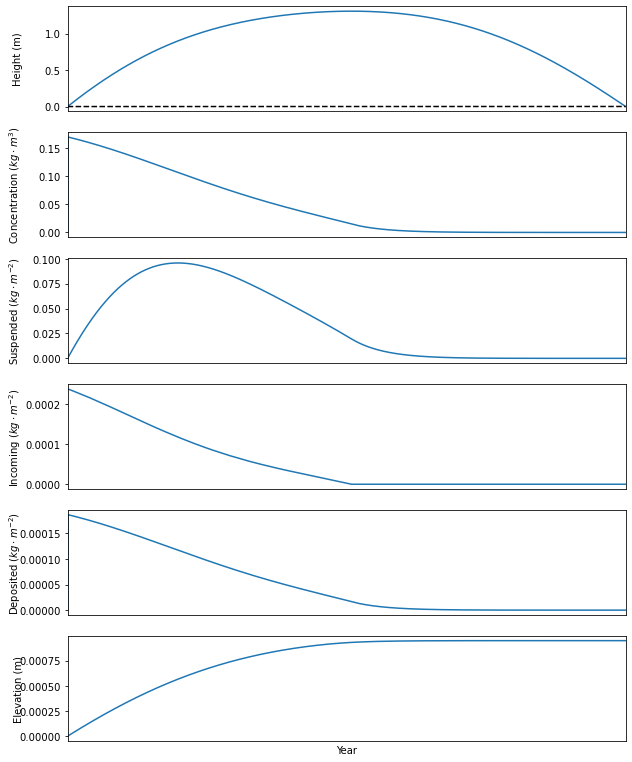

In [24]:
plot_data = data.copy()
plot_data = plot_data.sample(frac=1)
start = 0
end = -1
ticks = mpl.dates.YearLocator()

figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(10,15))
p1 = plot_data[start:end][['tide']].plot(ax=axes[0]).xaxis.set_visible(False)
plot_data[start:end][['elev']].plot(ax=axes[0], color='black', ls='--')
p2 = plot_data[start:end][['conc']].plot(ax=axes[1]).xaxis.set_visible(False)
p3 = plot_data[start:end][['suspended_sediment']].plot(ax=axes[2]).xaxis.set_visible(False)
p4 = plot_data[start:end][['incoming_sediment']].plot(ax=axes[3]).xaxis.set_visible(False)
p5 = plot_data[start:end][['deposited_sediment']].plot(ax=axes[4]).xaxis.set_visible(False)
p6 = plot_data[start:end][['elev']].plot(ax=axes[5])
axes[5].xaxis.set_major_locator(ticks)
axes[5].xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
axes[5].set_xlabel('Year')
ylabels = ['Height (m)', 'Concentration ($kg \cdot m^{3}$)', 'Suspended ($kg \cdot m^{-2}$)', 'Incoming ($kg \cdot m^{-2}$)', 'Deposited ($kg \cdot m^{-2}$)', 'Elevation (m)']
count = 0
for ax in axes:
    ax.margins(x=0)
    ax.set_ylabel(ylabels[count])
    ax.yaxis.set_label_coords(-0.08, 0.5)
    ax.get_legend().remove()
    count = count + 1

In [11]:
data

,elev,tide,bound_conc,conc,deposited_sediment,elev_change,depth,suspended_sediment,incoming_sediment
Datetime,,,,,,,,,
2014-05-18 00:08:37+06:00,0.800000,0.000208,0.8,0.0,0.0,0.0,0.0,0.0,NaN
2014-05-18 00:08:38+06:00,0.800000,0.000504,0.8,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-18 00:08:39+06:00,0.800000,0.000800,0.8,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-18 00:08:40+06:00,0.800000,0.001097,0.8,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-18 00:08:41+06:00,0.800000,0.001393,0.8,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2014-05-18 05:49:25+06:00,0.800369,0.001160,0.8,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-18 05:49:26+06:00,0.800369,0.000906,0.8,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-18 05:49:27+06:00,0.800369,0.000652,0.8,0.0,0.0,0.0,0.0,0.0,0.0
